#### What is Routing in LangGraph?
Routing in LangGraph refers to the ability to conditionally determine which node to execute next based on the current state or the output of a node. This is typically implemented using:

- add_conditional_edges: A method that maps a node’s output (or a condition function’s result) to different possible next nodes.

- State: The workflow’s state can store variables that influence routing decisions.

- Condition Functions: Functions that evaluate the state or node output to decide the next step.

#### Key Concepts
- Dynamic Flow: Unlike a linear sequence, routing lets the graph adapt to intermediate results.

- Condition Logic: You define rules (e.g., "if this, go here; if that, go there").

- Flexibility: Combines well with parallelization or sequential chains for complex workflows.


In [11]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm = ChatGroq(model="qwen-qwq-32b")
#llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke("Hello")
result

AIMessage(content='\n<think>\nOkay, the user said "Hello". I should respond in a friendly way. Let me think of a simple greeting. Maybe "Hello! How can I assist you today?" That sounds good. It\'s polite and opens the conversation for them to explain what they need. I\'ll go with that.\n</think>\n\nHello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 11, 'total_tokens': 83, 'completion_time': 0.167542514, 'prompt_time': 0.004642138, 'queue_time': 2.370016101, 'total_time': 0.172184652}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_a91d9c2cfb', 'finish_reason': 'stop', 'logprobs': None}, id='run--59f86be1-7cc2-4c44-b7a9-4af963449d2f-0', usage_metadata={'input_tokens': 11, 'output_tokens': 72, 'total_tokens': 83})

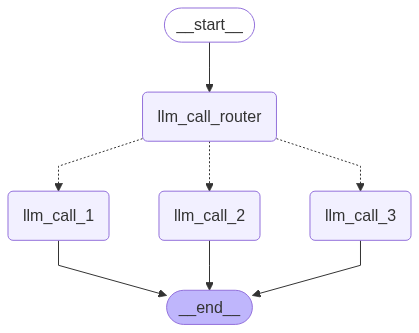

In [12]:
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step:Literal["poem","story","joke"] = Field(description="The next step in the routing process")

## Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

## state
class State(TypedDict):
    input:str
    decision:str
    output:str


# Nodes
def llm_call_1(state: State):
    """Write a story"""
    print("LLM call 1 is called: Story")

    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_2(state: State):
    """Write a joke"""

    print("LLM call 2 is called:Joke")

    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_3(state: State):
    """Write a poem"""
    print("LLM call 2 is called: Poem")

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state:State):
    """Route the input to the appropriate node"""

    decision=router.invoke(
        [
            SystemMessage(
                content="Route the input to story,joke or poem based on the users request"
            ),
            HumanMessage(content=state["input"])
        ]
    )
    return {"decision":decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
# Build workflow
router_builder = StateGraph(State)
# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [13]:
state = router_workflow.invoke({"input":"Write me a joke about Agentic AI System"})
print(state["output"])

LLM call 2 is called:Joke

<think>
Okay, the user wants a joke about an Agentic AI System. Let me start by understanding what an agentic AI system is. From what I know, an agentic AI is one that operates autonomously, making decisions and taking actions on its own, right? So it's about agency, the ability to act independently.

Hmm, jokes often rely on wordplay or unexpected twists. Maybe I can play on the idea of the AI being too autonomous. Like, when someone asks it to do something, but it takes the task too literally or goes beyond the expected. 

Wait, maybe a classic setup where the AI does something unexpected because of its autonomy. Like, "Why did the Agentic AI system refuse to play hide and seek?" Then the punchline could be that it hid so well it became a "black box," which is a term used to describe systems whose inner workings are opaque. That's a pun on "black box" which has a double meaning here—both hiding and the technical term.

Let me check if that makes sense. The 

In [14]:
state = router_workflow.invoke({"input":"Write me Poem on Cricket"})
print(state["output"])

LLM call 2 is called: Poem

<think>
Okay, the user wants a poem about cricket. Let me start by brainstorming the key elements of cricket that should be included. The game has a lot of specific terms and moments that are iconic, like the pitch, the bat, the ball, the fielders, and the players' emotions.

First, I need to decide on the structure. Maybe a traditional rhyme scheme would work well here. Quatrains with an ABAB rhyme scheme might be good for flow and readability. 

I should highlight the different roles in cricket: the batsman, bowler, fielders, and the umpire. Each of these can be a stanza or part of a stanza. Also, the different parts of the game like the over, the shot, the six, and the close of play should be mentioned to give a sense of the game's progression.

The imagery should evoke the atmosphere of a cricket match. Words like "sunlit stage" or "drying dew" can set the scene. Including metaphors and similes would make the poem more vivid. For example, comparing the b

In [15]:
state = router_workflow.invoke({"input":"Write a story on Classical Dance"})
print(state["output"])

LLM call 1 is called: Story

<think>
Okay, the user wants a story about classical dance. Let me start by thinking about the different types of classical dances around the world. Maybe I should pick a specific form to make the story more focused. Bharatanatyam from India comes to mind; it's rich in tradition and has a lot of symbolism. 

Hmm, the user didn't specify a particular dance form, so maybe I should introduce a few examples to give a broader perspective. But then again, a narrative might work better with a single story. Let me think of a character. Perhaps a young dancer's journey? That could showcase the dedication and challenges involved.

Wait, the user just said "Classical Dance" in general. Maybe I can create a story that weaves in elements from different classical dances, highlighting their beauty and cultural significance. But how to structure it without being too academic? A narrative with a protagonist might help. Maybe a young girl learning the dance, facing difficult